In [66]:
# linear algebra and data processing
import numpy as np
import pandas as pd 

#data visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# statistics
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# models + accuracy metrics
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")


In [67]:

# Loading the data
df_train = pd.read_csv('file:///home/papineau/Pharmaceutical_Sales_prediction_across_multiple_stores/data/train.csv')
df_test = pd.read_csv('file:///home/papineau/Pharmaceutical_Sales_prediction_across_multiple_stores/data/test.csv')
df_store = pd.read_csv('file:///home/papineau/Pharmaceutical_Sales_prediction_across_multiple_stores/data/store.csv')
df_sample_submission = pd.read_csv('file:///home/papineau/Pharmaceutical_Sales_prediction_across_multiple_stores/data/sample_submission.csv')

In [68]:

# merge the train/test sets with the stores set
full_train = pd.merge(left = df_train, right = df_store, how = 'inner', left_on = 'Store', right_on = 'Store')
full_test = pd.merge(left = df_test, right = df_store, how = 'inner', left_on = 'Store', right_on = 'Store')
print(full_train.shape)
print(full_test.shape)

(1017209, 18)
(41088, 17)


In [69]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [70]:
full_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        40992 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2                     41088 non-null  int

## Preprocessing before prediction

In [71]:
def preprocess_data(full_train, full_test):
    
    # '''preprocessing'''
    global train_features, test_features, train_target, categorical, numerical

    # train and target features
    train_features = full_train.drop(['Sales', 'Customers'], axis = 1) #drop the target feature + customers (~ will not be used for prediction)
    train_target  = full_train[['Sales']]
    test_features = full_test.drop(['Id'], axis = 1) #drop id, it's required only during submission

    #feature generation + transformations
    train_features['Date'] = pd.to_datetime(train_features.Date)
    train_features['Month'] = train_features.Date.dt.month.to_list()
    train_features['Year'] = train_features.Date.dt.year.to_list()
    train_features['Day'] = train_features.Date.dt.day.to_list()
    train_features['WeekOfYear'] = train_features.Date.dt.weekofyear.to_list()
    train_features['DayOfWeek'] = train_features.Date.dt.dayofweek.to_list()
    train_features['weekday'] = 1        # Initialize the column with default value of 1
    train_features.loc[train_features['DayOfWeek'] == 5, 'weekday'] = 0
    train_features.loc[train_features['DayOfWeek'] == 6, 'weekday'] = 0
    # train_features = train_features.drop(['Date'], axis = 1)
    train_features = train_features.drop(['Store'], axis = 1)

    test_features['Date'] = pd.to_datetime(test_features.Date)
    test_features['Month'] = test_features.Date.dt.month.to_list()
    test_features['Year'] = test_features.Date.dt.year.to_list()
    test_features['Day'] = test_features.Date.dt.day.to_list()
    test_features['WeekOfYear'] = test_features.Date.dt.weekofyear.to_list()
    test_features['DayOfWeek'] = test_features.Date.dt.dayofweek.to_list()
    test_features['weekday'] = 1        # Initialize the column with default value of 1
    test_features.loc[test_features['DayOfWeek'] == 5, 'weekday'] = 0
    test_features.loc[test_features['DayOfWeek'] == 6, 'weekday'] = 0
    # test_features = test_features.drop(['Date'], axis = 1)
    test_features = test_features.drop(['Store'], axis = 1)


    # numerical and categorical columns (train set)
    categorical = []
    numerical = []
    timestamp = []

    for col in train_features.columns:
        if train_features[col].dtype == object:
            categorical.append(col)
        elif train_features[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            numerical.append(col)
        else:
            timestamp.append(col)

    # Keep selected columns only
    my_cols = categorical + numerical + timestamp
    train_features = train_features[my_cols].copy()
    test_features = test_features[my_cols].copy()
    features = pd.concat([train_features, test_features]) #merge the features columns for uniform preprocessing

    # change dtypes for uniformity in preprocessing
    features.CompetitionOpenSinceMonth = features.CompetitionOpenSinceMonth.astype('Int64') 
    features.CompetitionOpenSinceYear = features.CompetitionOpenSinceYear.astype('Int64')
    features.Promo2SinceWeek = features.Promo2SinceWeek.astype('Int64') 
    features.Promo2SinceYear = features.Promo2SinceYear.astype('Int64')
    features["StateHoliday"].loc[features["StateHoliday"] == 0] = "0"



    # ''' actual preprocessing: the mighty pipeline '''
    # numeric
    for col in ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']:
        features[col] = features[col].fillna((int(features[col].mean()))) 
    features.PromoInterval = features.PromoInterval.fillna(features.PromoInterval.mode()[0])
    features.Open = features.Open.fillna(features.Open.mode()[0])
    features = pd.get_dummies(features, columns=['StoreType', 'Assortment', 'PromoInterval', 'StateHoliday'], drop_first=True)
    scaler = RobustScaler()
    c = ['DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'WeekOfYear', 'Month', 'Year', 'Day', 'WeekOfYear', 'weekday']
    features[numerical] = scaler.fit_transform(features[numerical].values)


    return features

In [72]:
features = preprocess_data(full_train, full_test)
features = features.drop(['Date'], axis = 1)
features.head()

,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0.25,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1,0.00,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,-0.25,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,-0.50,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
4,-0.75,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0


In [73]:
# reconstruct train and test sets
def reconstruct_sets(features):
    global x_train, x_val, y_train, y_val
    # global train_set
    # original train and test sets
    x_train = features.iloc[:len(train_features), :]
    x_test = features.iloc[len(train_features):, :]
    y_train = train_target
    # train_set = pd.concat([x_train, y_train], axis=1)

    # updated train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = .20, random_state = 0)


    return x_train, x_val, y_train, y_val, x_test

In [74]:
x_train, x_val, y_train, y_val, x_test = reconstruct_sets(features)
# log transformation on target variable
y_train = np.log1p(y_train['Sales'])
y_val = np.log1p(y_val['Sales'])
x_train.shape, x_val.shape, y_train.shape, y_val.shape, x_test.shape

((813767, 25), (203442, 25), (813767,), (203442,), (41088, 25))

## Modelling starts

In [75]:
#Random forests Regressor

# Fitting
clf = RandomForestRegressor(n_estimators = 15)
clf.fit(x_train, y_train)

# validation
y_pred = clf.predict(x_val)
mean_squared_error(y_val, y_pred)
print("Mean squared error for RF on validation data =", mean_squared_error(y_val, y_pred))
print("Mean absolute error for RF on validation data =", mean_absolute_error(y_val, y_pred))

Mean squared error for RF on validation data = 0.01835856514211326
Mean absolute error for RF on validation data = 0.07589597763097337


In [76]:

# LinearRegression

#fitting
regressor = LinearRegression()
regressor.fit(x_train, y_train)

#validation
# scores = cross_val_score(estimator = regressor, X = x_train, y = y_train, cv = 5)
regressor_pred = regressor.predict(x_val)
print("Mean squared error for sLR on validation data =", mean_squared_error(y_val, regressor_pred))
print("Mean absolute error for SLR on validation data =", mean_absolute_error(y_val, regressor_pred))

Mean squared error for sLR on validation data = 0.11848353838196156
Mean absolute error for SLR on validation data = 0.2527261289148539


In [77]:
# ExtremeBooster

#fitting
xgb = XGBRegressor(random_state = 42)
xgb.fit(x_train, y_train)

# validation
# scores = cross_val_score(estimator = xgb, X = x_train, y = y_train, cv = 5)
xgb_pred = xgb.predict(x_val)
print("Mean absolute error for xgb on validation data =", mean_absolute_error(y_val, xgb_pred))
print("Mean squared error for xgb on validation data =", mean_squared_error(y_val, xgb_pred))

Mean absolute error for xgb on validation data = 0.12452821718981405
Mean squared error for xgb on validation data = 0.03187673969685498


## Time Series Analysis and Forecasting with Prophet

### Forecasting for the next 6 weeks for the first store

In [78]:
# prophet by Facebook
from fbprophet import Prophet


In [79]:
# importing data
df = pd.read_csv("file:///home/papineau/Pharmaceutical_Sales_prediction_across_multiple_stores/data/train.csv")

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [80]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


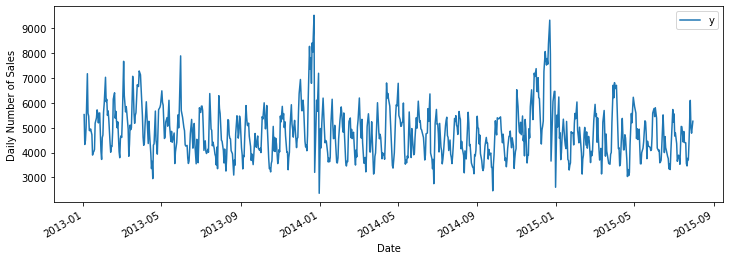

In [81]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

## Modeling Holidays

The StateHoliday variable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school holidays in the dataset at which certain stores close doors.

In [82]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [83]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, daily_seasonality=True, holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [84]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4113.505589,2388.090897,5684.109236
817,2015-09-06,3850.903929,2198.798933,5484.784368
818,2015-09-07,4182.475307,2564.762526,5850.434810
819,2015-09-08,3685.187022,2127.782267,5350.443526
820,2015-09-09,3571.360016,1981.562417,5057.948493
821,2015-09-10,3484.112605,1878.279154,5144.375332
822,2015-09-11,3739.792463,2115.860980,5330.195401



The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [85]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

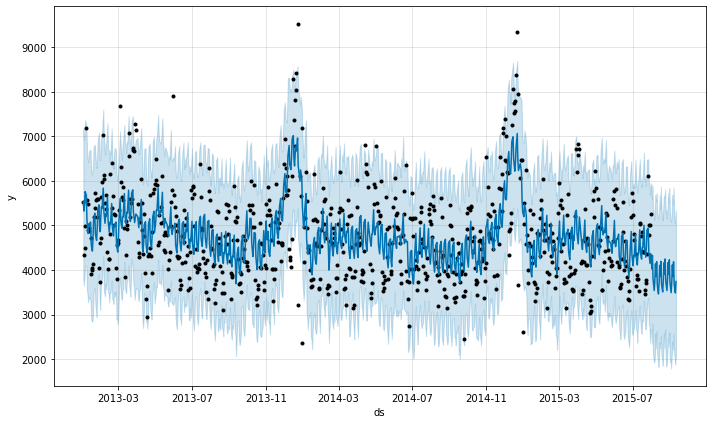

In [86]:

# visualizing predicions
my_model.plot(forecast);

As we see Prophet catches the trends and most of the time gets future values right.

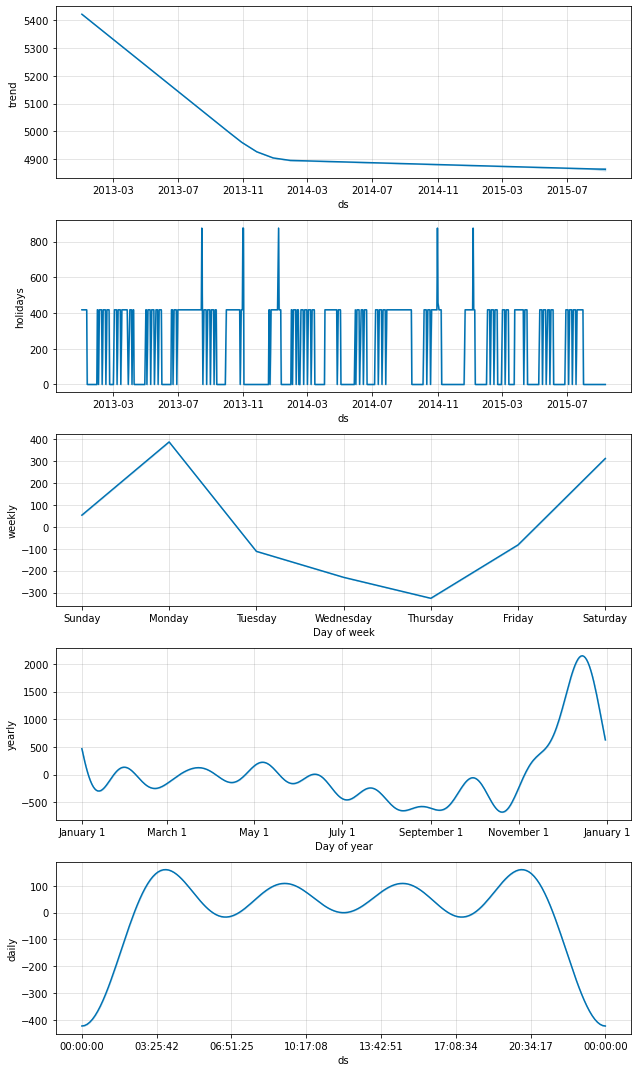

In [87]:
my_model.plot_components(forecast);


The first plot shows that the monthly sales of store number 1 has been linearly decreasing over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays.